# Filtracja bilateralna

## Konwolucja obrazu z filtrem o zadanych współczynnikach

Splot (konwolucję) obrazu wejściowego $I$ z filtrem $\psi$ dla ustalonego punktu obrazu $\mathbf{x}$ można przedstawić następująco:

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||)I(\mathbf{p})
\end{equation}

gdzie:
- $\hat{I}$ jest obrazem wynikowym (przefiltrowanym),
- $W_N = \sum_y \psi(y)$ jest parametrem normalizującym współczynniki filtra $\psi$,
- $||\cdot||$ jest odległością między punktami obrazu $\mathbf{x}$ i $\mathbf{p}$ według ustalonej metryki (np. norma $L_2$). Uwaga, proszę pamiętać, że zarówno $\mathbf{x}$, jak i $\mathbf{p}$ to współrzędne przestrzenne,
- $\eta(\mathbf{x})$ jest otoczeniem punktu $\mathbf{x}$.

Funkcja $\psi$ decyduje o charakterze filtracji. Dla filtru Gaussowskiego:

\begin{equation}
\psi(y) = G_{\delta_s}(y)
\end{equation}

gdzie: $G_{\delta_s}(y)$ jest funkcją Gaussa z parametrem skali $\delta_s$.

Opisaną powyżej filtrację realizowaliśmy w ramach ćwiczenia "Przetwarzanie wstępne. Filtracja kontekstowa."

## Filtracja bilateralna

Wadą klasycznego splotu jest brak adaptacji współczynników filtra do lokalnego otoczenia $\eta(\mathbf{x})$ filtrowanego punktu $\mathbf{x}$.
Oznacza to wykorzystanie tych samych współczynników filtra $\psi$ niezależnie od tego czy otoczenie jest względnie jednorodne lub zawiera krawędzie obiektów (w tym przypadku dochodzi do "rozmywania" krawędzi).
Filtracja bilateralna uwzględnia lokalne otoczenie filtrowanego punktu, w ten sposób, że parametry filtra zmieniają się w zależności od "wyglądu" otocznia.


Współczynniki filtra obliczane są na podstawie odległości filtrowanego punktu $\mathbf{x}$ od każdego punktu otoczenia $\mathbf{p}$ w dziedzinie przestrzennej obrazu (tak jak przy typowym filtrze np. Gaussa) oraz odległości punktów w przeciwdziedzinie obrazu (np. na podstawie różnicy w jasności pikseli dla obrazu w odcieniach szarości):

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||) \gamma(|I(\mathbf{p}) - I(\mathbf{x})|) I(\mathbf{p})
\end{equation}
gdzie:
- $W_N$ jest współczynnikiem normalizującym filtr,
- $\gamma$ jest funkcją odległości w przeciwdziedzinie obrazu, np. $\gamma(y)=\exp(-\frac{y^2}{2\delta_r^2})$
- parametr $\delta_r$ jest utożsamiany z poziomem szumu w obrazie i należy go dobrać w sposób empiryczny.

Proszę chwilę zastanowić się nad powyższym równaniem, w szczególności nad funkcją $\gamma$. Proszę wyznaczyć, jaka będzie wartość funkcji dla pikseli podobnych (różnica 0, 1, 2), a skrajnie różnych (255, 200).

##  Realizacja ćwiczenia

### Wczytanie danych

1. Wczytaj dane z pliku *MR_data.mat*. W tym celu wykorzystaj funkcję `loadmat` z pakietu scipy:
        from scipy.io import loadmat
        mat = loadmat('MR_data.mat')

2. Wczytany plik zawiera 5 obrazów: *I_noisefree*, *I_noisy1*, *I_noisy2*, *I_noisy3* oraz *I_noisy4*. Odczytać je można w następujący sposób:
        Input = mat['I_noisy1']

3.Wyświetl wybrany obraz z pliku *MR_data.mat*. Zagadka - co to za obrazowanie medyczne?

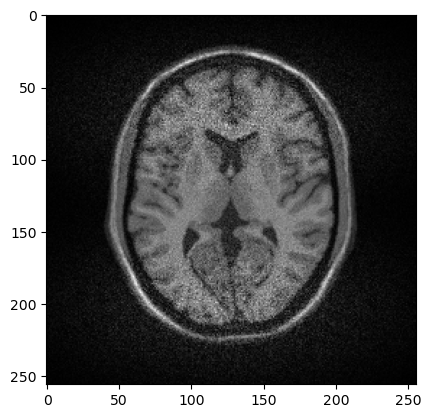

In [1]:
import cv2
import os
import requests
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal
from scipy.io import loadmat
import math

url = 'https://raw.githubusercontent.com/vision-agh/poc_sw/master/07_Bilateral/'

fileNames = ["MR_data.mat"]
for fileName in fileNames:
  if not os.path.exists(fileName):
      r = requests.get(url + fileName, allow_redirects=True)
      open(fileName, 'wb').write(r.content)

mat = loadmat('MR_data.mat')
I1 = mat['I_noisefree']
I2 = mat['I_noisy1']
I3 = mat['I_noisy2']
I4 = mat['I_noisy3']
I5 = mat['I_noisy4']
plt.imshow(I3, cmap="gray")

### "Klasyczna" konwolucja

1. Zdefiniuj parametry filtra Gaussowskiego: rozmiar okna i wariancję $\delta_S$.
2. Oblicz współczynniki filtra na podstawie zdefiniowanych parametrów (najprościej w ramach podwójnej pętli for).
2. Sprawdź ich poprawność i zwizualizuj filtr (tak jak w ćwiczeniu pt. "Przetwarzanie wstępne. Filtracja kontekstowa.").
3. Wykonaj kopię obrazu wejściowego: `IConv = Input.copy()`
4. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
5. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
6. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentem tej funkcji są aktualnie przetwarzane okno i współczynniki filtra.
7. Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.
8. Wyświetl wynik filtracji.
9. Porównaj wynik z obrazem oryginalnym.

In [2]:
def fgaussian(size, sigma):
     m = n = size
     h, k = m//2, n//2
     x, y = np.mgrid[-h:h+1, -k:k+1]
     g = np.exp(-(x**2 + y**2)/(2*sigma**2))
     return g /g.sum()

def mesh(fun, size):
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    X = np.arange(-size//2, size//2, 1)
    Y = np.arange(-size//2, size//2, 1)
    X, Y = np.meshgrid(X, Y)
    Z = fun

    ax.plot_surface(X, Y, Z)
    plt.show()

def new_value(window, mask):
    X, Y = window.shape
    result = np.zeros(window.shape)

    for i in range(Y):
        for j in range(X):
            result[i, j] = window[i, j] * mask[i, j]
    return np.sum(result) / np.sum(mask)

/var/folders/bf/yds996dn4h3d3zytfpz42rnc0000gn/T/ipykernel_77541/844771125.py:10: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


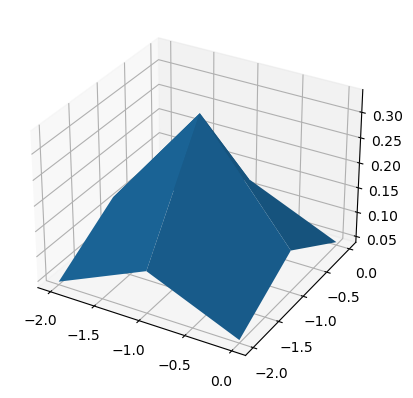

In [3]:
M_ = fgaussian(3, 0.7)
mesh(M_, 3)

In [4]:
def conv(img, size, sigma):
    x = y = size // 2
    M = fgaussian(size, sigma)
    IConv = img.copy()

    for i in range(x, img.shape[0] - x):
        for j in range(y, img.shape[1] - y):
            I = IConv[i - x : i + x + 1, j - y : j + y + 1]
            IConv[i][j] = new_value(I, M)

    fig, axs = plt.subplots(1, 3)
    fig.set_size_inches(12, 6)
    axs[0].imshow(img, cmap="gray")
    axs[1].imshow(IConv, cmap="gray")
    axs[2].imshow(np.array(img.astype("int8") - IConv.astype("int8")), cmap="gray")
    return IConv

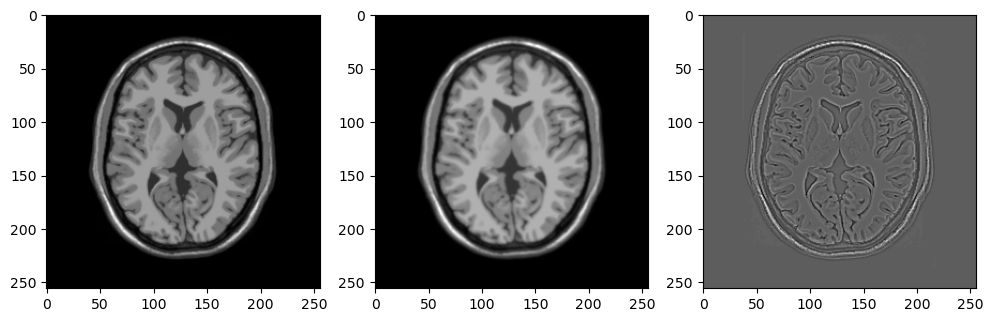

In [5]:
R1 = conv(I1, 3, 0.7)

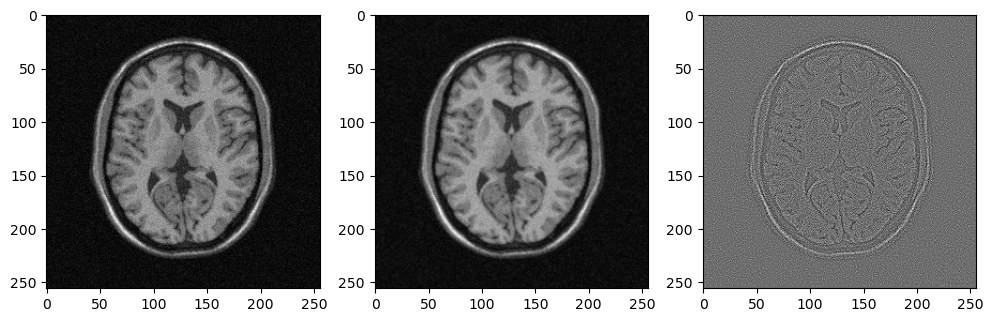

In [6]:
R2 = conv(I2, 5, 0.5)

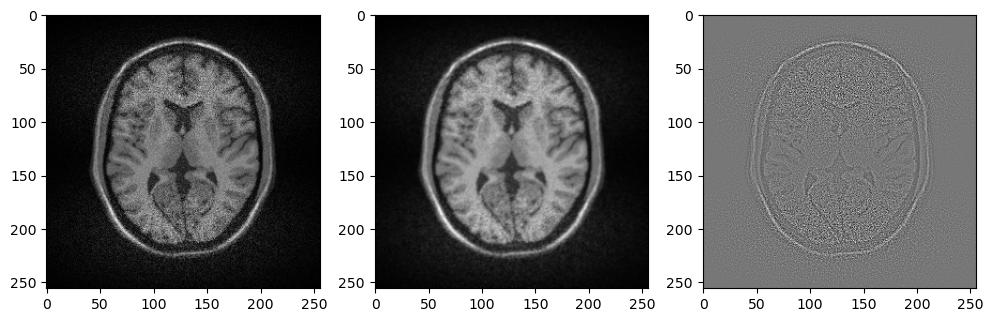

In [7]:
R3 = conv(I3, 5, 0.7)

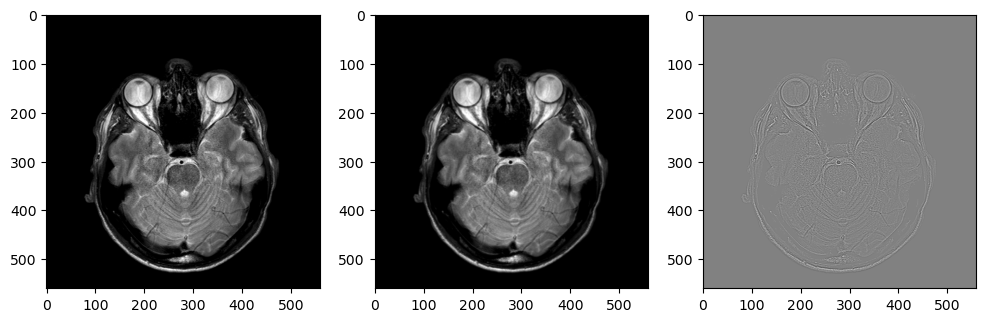

In [8]:
R4 = conv(I4, 5, 0.6)

### Filtracja bilateralna

1. Zdefiniuj dodatkowy parametr: wariancję $\delta_R$.
3. Wykonaj kopię obrazu wejściowego: `IBilateral = Input.copy()`
4. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
5. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
6. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentami funkcji są aktualnie przetwarzane okno, współczynniki filtra gausowskiego (takie same jak wcześniej) i wariancja $\delta_R$.
7. Oblicz odległość w przeciwdziedzinie (dla wartości pikseli).
8. Oblicz funkcję Gaussa dla obliczonych odległości z zadanym parametrem.
9. Wykonaj normalizację obliczonych współczynników.
10. Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.
11. Wyświetl wynik filtracji.
12. Porównaj wynik z obrazem oryginalnym.

In [9]:
def new_value_bil(window, mask, sigma):
    X, Y = window.shape
    output = np.zeros(window.shape)
    norm_ = 0
    x = X//2
    y = Y//2

    for i in range(X):
        for j in range(Y):
            distance = abs(window[i, j] - window[x, y])
            g = np.exp(-distance / (2 * sigma**2))
            output[i,j] = g * window[i, j] * mask[i,j]
            norm_ += g * mask[i,j]
    return np.sum(output) / norm_

In [10]:
def bilateral(img, size, sigma, sigma_r):
    x = y = size // 2
    M = fgaussian(size, sigma)
    IBilateral = img.copy()

    for i in range(x, img.shape[0] - x):
        for j in range(y, img.shape[1] - y):
            I = img[i - x : i + x + 1, j - y : j + y + 1]
            IBilateral[i][j] = new_value_bil(I, M, sigma_r)

    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(12, 6)
    axs[0].imshow(img, cmap="gray")
    axs[1].imshow(IBilateral, cmap="gray")

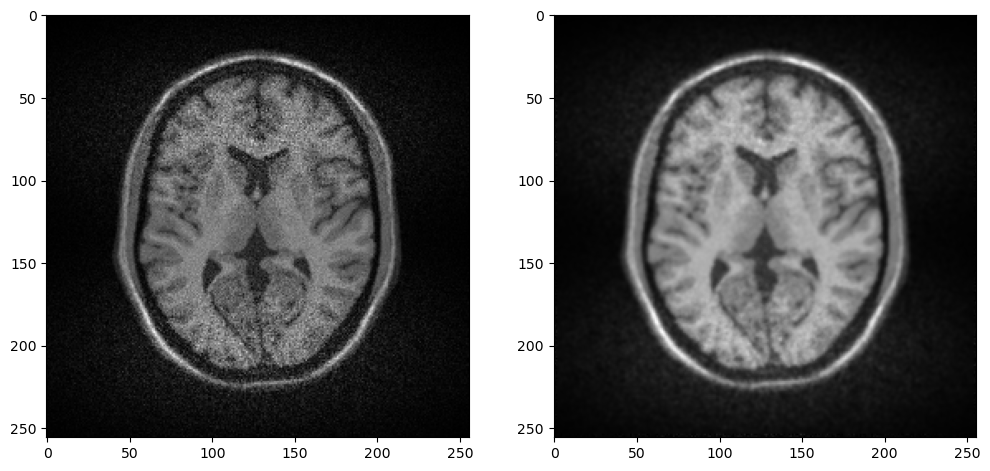

In [11]:
bilateral(I3, 5, 1, 15)

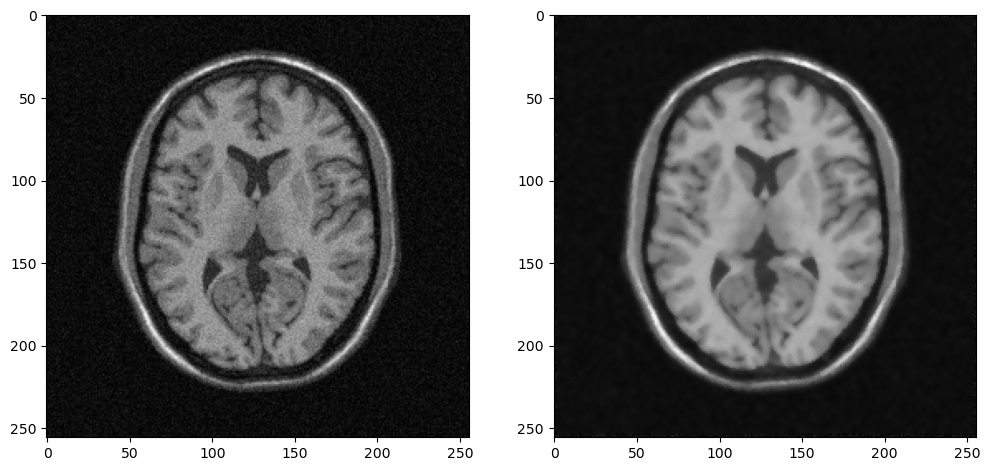

In [12]:
bilateral(I2, 5, 3, 5)

/var/folders/bf/yds996dn4h3d3zytfpz42rnc0000gn/T/ipykernel_77541/1474668671.py:10: RuntimeWarning: overflow encountered in ubyte_scalars
  distance = abs(window[i, j] - window[x, y])


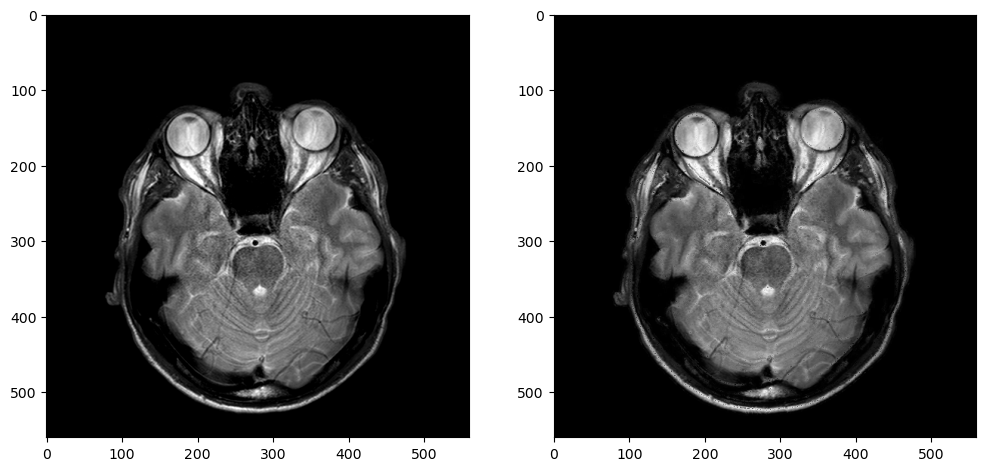

In [13]:
bilateral(I4, 5, 1, 0.7)

/var/folders/bf/yds996dn4h3d3zytfpz42rnc0000gn/T/ipykernel_77541/1474668671.py:10: RuntimeWarning: overflow encountered in ubyte_scalars
  distance = abs(window[i, j] - window[x, y])


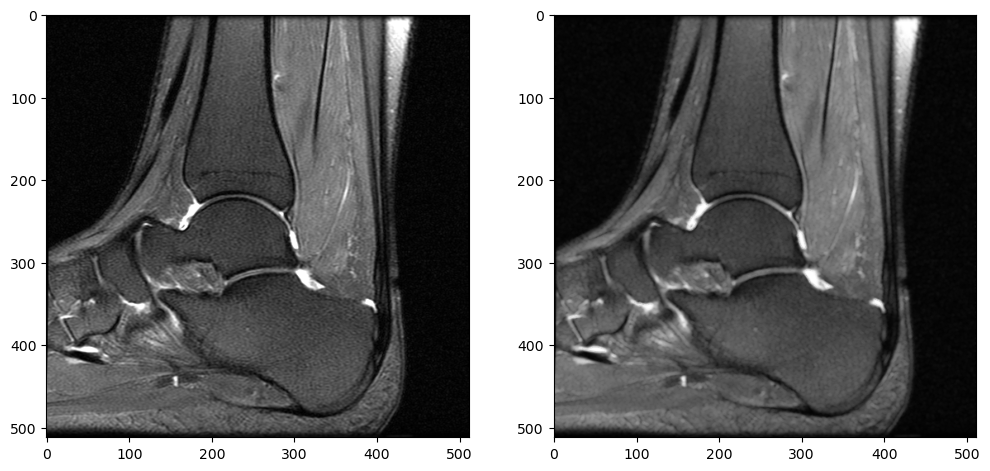

In [14]:
bilateral(I5, 5, 1, 10)